# Siena Galaxy Mask
This notebook will update the Siena galaxy mask for DESI ELGs.

## Density Fluctuations Before (Old Masking Radius)
First, let's checkout the trends when `maskbits=1, 2, 3` are applied. 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import modules as ms
from astropy import units as u
from time import time

In [2]:
loader =  ms.DataLoader(maskbits=[1, 12, 13])

data_dir            : /fs/ess/PHS0336/data/elgmask
gaia_path           : /fs/ess/PHS0336/data/elgmask/gaia_lrg_mask_v1.fits
gaia_suppl_path     : /fs/ess/PHS0336/data/elgmask/gaia_reference_suppl_dr9.fits
gaia_columns        : ['RA', 'DEC', 'mask_mag']
target_class        : ELG
maskbits            : [1, 12, 13]
min_nobs            : 1



In [3]:
field = 'south'
cat = loader.read_cat(field)         # read target catalog
ran = loader.read_randoms(field)     # read random catalog
siena = loader.read_siena(field)       # read siena gal catalog

# of targets: 35360631
# of targets (after maskbits=[1, 12, 13]): 35360631
# of targets (after LMC cut): 34836102
# of targets (after min_nobs >= 1): 34836102
# of targets: 155396056
# of targets (after maskbits=[1, 12, 13]): 153649077
# of targets (after LMC cut): 151878758
# of targets (after min_nobs >= 1): 143383338
# of Siena objects: 383620
# of gaia objects (south): 298151


In [ ]:
ms.check_maskbits(cat)
ms.check_maskbits(ran)

sky2 = ms.cat2sky(cat)
sky3 = ms.cat2sky(ran)

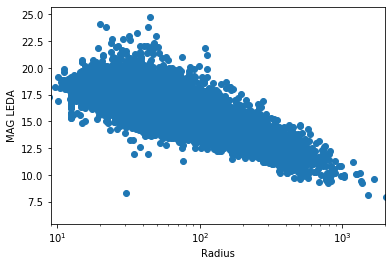

In [6]:
plt.axes(xlabel='Radius', ylabel='MAG LEDA', xscale='log', xlim=(9, 2.0e3))
plt.scatter(siena['radius'], siena['MAG_LEDA'])

In [4]:
siena_mag_list = np.array([7.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5])
print(siena_mag_list)

[ 7.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5]


In [5]:
field

'south'

7.5 <= Siena MAG LEDA < 9.5 10 siena galaxies
70761 nearby objects around 10 siena galaxies
288157 nearby randoms around 10 siena galaxies
done in 90.64469575881958


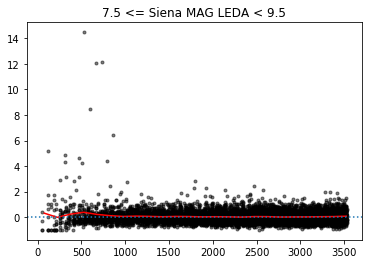

9.5 <= Siena MAG LEDA < 10.5 38 siena galaxies
242919 nearby objects around 36 siena galaxies
950100 nearby randoms around 36 siena galaxies
done in 6.75324559211731


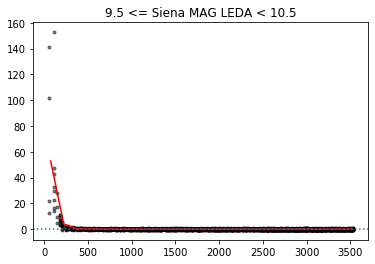

10.5 <= Siena MAG LEDA < 11.5 113 siena galaxies
731166 nearby objects around 109 siena galaxies
2939163 nearby randoms around 109 siena galaxies
done in 16.949565887451172


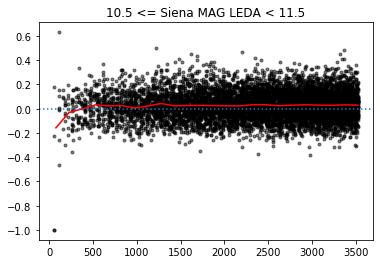

11.5 <= Siena MAG LEDA < 12.5 296 siena galaxies
1576807 nearby objects around 291 siena galaxies
6298822 nearby randoms around 291 siena galaxies
done in 22.22804093360901


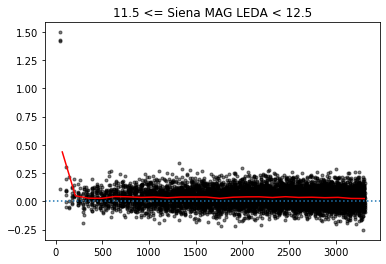

12.5 <= Siena MAG LEDA < 13.5 829 siena galaxies
3547375 nearby objects around 803 siena galaxies
14548674 nearby randoms around 803 siena galaxies
done in 38.619466066360474


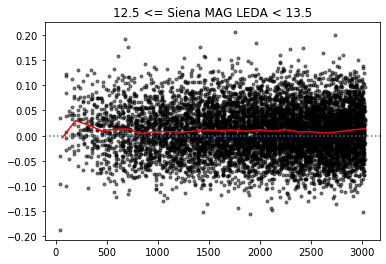

13.5 <= Siena MAG LEDA < 14.5 2950 siena galaxies
7062039 nearby objects around 2830 siena galaxies
28864982 nearby randoms around 2830 siena galaxies
done in 67.29108452796936


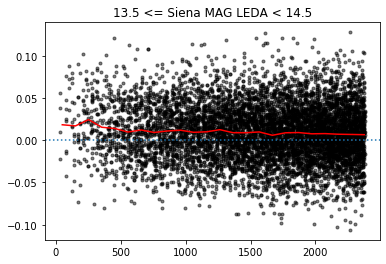

14.5 <= Siena MAG LEDA < 15.5 13820 siena galaxies
17618064 nearby objects around 13214 siena galaxies
72262553 nearby randoms around 13214 siena galaxies
done in 187.75277161598206


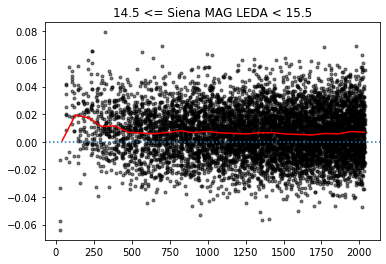

In [9]:
nbins = 101

for i in range(0, len(siena_mag_list)-1):
    
    t0 = time()
    siena_min, siena_max = siena_mag_list[i:i+2]
    smask = (siena['MAG_LEDA'] >= siena_min) & (siena['MAG_LEDA'] < siena_max)
    siena1 = siena[smask]
    
    title = '{:.1f} <= Siena MAG LEDA < {:.1f}'.format(siena_min, siena_max, len(siena1))
    print(title, '{} siena galaxies'.format(len(siena1)))       
    
    search_radius = np.minimum(siena1['radius'].max() * 4.1, 3600)
    sky1 = ms.cat2sky(siena1)
    
    # objects
    idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*ms.arcsec)
    # randoms
    idx1_ran, idx2_ran, d2d_ran, _ = sky3.search_around_sky(sky1, seplimit=search_radius*ms.arcsec)

    d2d = np.array(d2d.to(u.arcsec))  # convert distances to numpy array in arcsec
    d_ra, d_dec = ms.get_residuals(siena1[idx1], cat[idx2])
    d2d_ran = np.array(d2d_ran.to(u.arcsec))  # convert distances to numpy array in arcsec
    d_ra_ran, d_dec_ran = ms.get_residuals(siena1[idx1_ran], ran[idx2_ran])
    print('{} nearby objects around {} siena galaxies'.format(len(np.unique(idx2)), len(np.unique(idx1))))
    print('{} nearby randoms around {} siena galaxies'.format(len(np.unique(idx2_ran)), len(np.unique(idx1_ran))))
    
    bins, density, __ = ms.get_density(d_ra, d_dec, d2d, search_radius, nbins=nbins)
    bins_ran, density_ran, counts_ran = ms.get_density(d_ra_ran, d_dec_ran, d2d_ran, search_radius, nbins=nbins)
    
    sf = len(cat)/len(ran)
    reldens = ms.get_relative_density(bins, density, density_ran*sf, nbins)

    np.savez(f'dens_elg_siena_gmag_{i}_{field}.npz', **{'bins':bins, 'density':density, 
                                     'density_ran':density_ran, 
                                     'counts_ran':counts_ran,
                                     'sf':sf,
                                     'reldens':reldens})
    
    print(f'done in {time()-t0}')
    
    plt.figure()
    plt.title(title)
    plt.plot(*reldens[0], color='r')
    plt.plot(reldens[1][0].flatten(), reldens[1][1].flatten()-1.0, 
         marker='.', ls='none', alpha=0.5, color='k', zorder=-10)
    plt.axhline(0.0, ls=':')
    #plt.xlim(-10., 3700.)
    #plt.ylim(-1.1, 3.2)
    plt.show()

### Flag Galaxies
In this step we use the new star radius to tag galaxies.

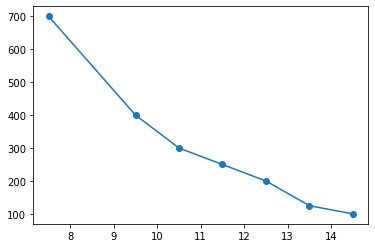

In [6]:
radii = [700., 400., 300., 250., 200., 125., 100.]
plt.plot(siena_mag_list[:-1], radii, 'o-')

In [7]:
from scipy.interpolate import interp1d

In [8]:
radii_int = interp1d(siena_mag_list[:-1], radii, bounds_error=False, fill_value='extrapolate')

In [9]:
is_good = siena['MAG_LEDA'] < 15.5

In [10]:
siena = siena[is_good]

In [11]:
siena['radius_mag'] = radii_int(siena['MAG_LEDA'])
siena[:10]

MAG_LEDA,RA,DEC,D26,radius,radius_mag
float32,float64,float64,float32,float32,float64
15.241,227.47031353123606,13.256402782093659,0.9032927,54.197563,81.47499561309814
15.075,182.19273883051247,24.94636588877294,1.7708806,106.25284,85.62500476837158
15.262,230.52173016493063,5.854855768747279,1.4420841,86.52505,80.9499979019165
15.23,207.14850301883672,24.01506953505597,1.169724,70.18344,81.7500114440918
15.066,149.66706146064135,28.87755539317504,1.7768618,106.61171,85.85000038146973
15.217,199.74887796106626,30.780989500596743,1.3532857,81.19714,82.07499980926514
14.837,152.18760597860927,9.460501472977464,2.0677059,124.062355,91.57500267028809
15.449,130.46557454827584,19.70249784275785,1.6248319,97.489914,76.27499103546143
15.486,138.93018246534947,15.219639151197997,0.6573303,39.439816,75.3499984741211


In [12]:
field

'south'

In [13]:
from sklearn.neighbors import KDTree

def radec2pos(ra, dec):
    """ converting ra dec to position on a unit sphere.
        ra, dec are in degrees.
    """
    pos = np.empty(len(ra), dtype=('f8', 3))
    ra = ra * (np.pi / 180)
    dec = dec * (np.pi / 180)
    pos[:, 2] = np.sin(dec)
    pos[:, 0] = np.cos(dec) * np.sin(ra)
    pos[:, 1] = np.cos(dec) * np.cos(ra)
    return pos

def veto(coord, center, R):
    """
        Returns a veto mask for coord. any coordinate within R of center
        is vet.
        Parameters
        ----------
        coord : (RA, DEC)
        center : (RA, DEC)
        R     : degrees
        Returns
        -------
        Vetomask : True for veto, False for keep.
    """
    pos_stars = radec2pos(center[0], center[1])
    R = 2 * np.sin(np.radians(R) * 0.5)
    pos_obj = radec2pos(coord[0], coord[1])
    tree = KDTree(pos_obj)
    vetoflag = np.zeros(len(pos_obj), dtype='?')
    arg = tree.query_radius(pos_stars, r=R)
    arg = np.concatenate(arg)
    vetoflag[arg] = True
    return vetoflag


# data masking
radius_deg = siena['radius_mag'].data / 3600 # deg
center = (siena['RA'].data, siena['DEC'].data)
coord = (cat['RA'].data, cat['DEC'].data)
is_bad = veto(coord, center, radius_deg)
np.save(f'is_bad_{field}_siena.npy', is_bad)

# random masking
coordr = (ran['RA'].data, ran['DEC'].data)
is_badr = veto(coordr, center, radius_deg)
np.save(f'is_badr_{field}_siena.npy', is_badr)

In [14]:
siena[:4]

MAG_LEDA,RA,DEC,D26,radius,radius_mag
float32,float64,float64,float32,float32,float64
15.241,227.47031353123606,13.256402782093659,0.9032927,54.197563,81.47499561309814
15.075,182.19273883051247,24.94636588877294,1.7708806,106.25284,85.62500476837158
15.262,230.52173016493063,5.854855768747279,1.4420841,86.52505,80.9499979019165
15.23,207.14850301883672,24.01506953505597,1.169724,70.18344,81.7500114440918


In [ ]:
is_bad.shape

In [20]:
len(cat)

34836102

In [21]:
field

'south'

In [ ]:
is_badr = np.load(f'is_badr_{field}_siena.npy')
is_bad = np.load(f'is_bad_{field}_siena.npy')

cat = cat[~is_bad]
ran = ran[~is_badr]

sky2 = ms.cat2sky(cat)
sky3 = ms.cat2sky(ran)

nbins = 101
for i in range(0, len(siena_mag_list)-1):
    
    t0 = time()
    siena_min, siena_max = siena_mag_list[i:i+2]
    smask = (siena['MAG_LEDA'] >= siena_min) & (siena['MAG_LEDA'] < siena_max)
    siena1 = siena[smask]
    
    title = '{:.1f} <= Siena MAG LEDA < {:.1f}'.format(siena_min, siena_max, len(siena1))
    print(title, '{} siena galaxies'.format(len(siena1)))       
    
    search_radius = np.minimum(siena1['radius'].max() * 4.1, 3600)
    sky1 = ms.cat2sky(siena1)
    
    # objects
    idx1, idx2, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*ms.arcsec)
    # randoms
    idx1_ran, idx2_ran, d2d_ran, _ = sky3.search_around_sky(sky1, seplimit=search_radius*ms.arcsec)

    d2d = np.array(d2d.to(u.arcsec))  # convert distances to numpy array in arcsec
    d_ra, d_dec = ms.get_residuals(siena1[idx1], cat[idx2])
    d2d_ran = np.array(d2d_ran.to(u.arcsec))  # convert distances to numpy array in arcsec
    d_ra_ran, d_dec_ran = ms.get_residuals(siena1[idx1_ran], ran[idx2_ran])
    print('{} nearby objects around {} siena galaxies'.format(len(np.unique(idx2)), len(np.unique(idx1))))
    print('{} nearby randoms around {} siena galaxies'.format(len(np.unique(idx2_ran)), len(np.unique(idx1_ran))))
    
    bins, density, __ = ms.get_density(d_ra, d_dec, d2d, search_radius, nbins=nbins)
    bins_ran, density_ran, counts_ran = ms.get_density(d_ra_ran, d_dec_ran, d2d_ran, search_radius, nbins=nbins)
    
    sf = len(cat)/len(ran)
    reldens = ms.get_relative_density(bins, density, density_ran*sf, nbins)

    np.savez(f'dens_elg_siena_gmag_{i}_{field}_after.npz', **{'bins':bins, 'density':density, 
                                     'density_ran':density_ran, 
                                     'counts_ran':counts_ran,
                                     'sf':sf,
                                     'reldens':reldens})
    
    print(f'done in {time()-t0}')
    
    #plt.figure()
    #plt.title(title)
    #plt.plot(*reldens[0], color='r')
    #plt.plot(reldens[1][0].flatten(), reldens[1][1].flatten()-1.0, 
    #     marker='.', ls='none', alpha=0.5, color='k', zorder=-10)
    #plt.axhline(0.0, ls=':')
    #plt.xlim(-10., 3700.)
    #plt.ylim(-1.1, 3.2)
    #plt.show()

7.5 <= Siena MAG LEDA < 9.5 10 siena galaxies
69369 nearby objects around 10 siena galaxies
283541 nearby randoms around 10 siena galaxies
done in 90.1274766921997
9.5 <= Siena MAG LEDA < 10.5 38 siena galaxies
236861 nearby objects around 36 siena galaxies
935823 nearby randoms around 36 siena galaxies
done in 7.160706520080566
10.5 <= Siena MAG LEDA < 11.5 113 siena galaxies
723662 nearby objects around 109 siena galaxies
2908323 nearby randoms around 109 siena galaxies
done in 16.89957094192505
11.5 <= Siena MAG LEDA < 12.5 296 siena galaxies
1562415 nearby objects around 291 siena galaxies
6242519 nearby randoms around 291 siena galaxies
done in 22.22378373146057
12.5 <= Siena MAG LEDA < 13.5 829 siena galaxies
3524130 nearby objects around 803 siena galaxies
14454411 nearby randoms around 803 siena galaxies
done in 36.23734164237976
13.5 <= Siena MAG LEDA < 14.5 2950 siena galaxies
7021360 nearby objects around 2830 siena galaxies
28710359 nearby randoms around 2830 siena galaxies